## 1.文件读取
notes:
- !shell command 可以再 jupyter 里面执行 shell 命令
- wiki 数据提取
- pandas读取文件。常见中文编码方式（e.g. 'gb18030'）。
- pandas对表中数据进行filter（titanic_train）
- read from pickle

## 2.正则表达式
- html 文件中用正则抓取 http url

## 3.n-gram
用n-gram计算句子、短语的概率
### 3.1 词频统计 (BOW)
- calculation of BOW see **corpus_processing_doc.ipynb**
- 生成可以统计词频的函数的函数（lisp风格的变量作用于trick）
- 画出词频的分布曲线

============= 1-gram word =============
total word count of corpus: 160538963
total vocabulary count: 924020
============= 2-gram word =============
total word count of corpus: 63557530
total vocabulary count: 749114
============= 1-gram char =============
total word count of corpus: 389334319
total vocabulary count: 9727
============= 2-gram char =============
total word count of corpus: 355228867
total vocabulary count: 948930


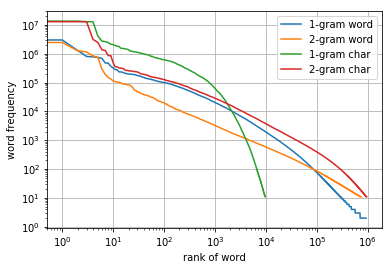

In [2]:
import matplotlib.pyplot as plt
import corpus_processing as cp
from debug_tools import timer, debug_print

count_ngram1word = cp.load_obj('data/count_ngram1word')
count_ngram2word = cp.load_obj('data/count_ngram2word')
count_ngram1char = cp.load_obj('data/count_ngram1char')
count_ngram2char = cp.load_obj('data/count_ngram2char')

legend = []
def visualize_counter(word_count, name):
    global legend
    legend.append(name)
    freq = [f for gram, f in word_count.most_common()]
    plt.figure('counter')
    plt.loglog(freq)
    plt.grid(True)
    plt.xlabel('rank of word')
    plt.ylabel('word frequency')
    plt.legend(legend)
    print('=============',name,'=============')
    print('total word count of corpus:', sum(freq))
    print('total vocabulary count:', len(freq))
    
visualize_counter(count_ngram1word,'1-gram word')
visualize_counter(count_ngram2word,'2-gram word')
visualize_counter(count_ngram1char,'1-gram char')
visualize_counter(count_ngram2char,'2-gram char')
plt.show()

### 3.2 unigram
$\textbf{w} = w_1...w_i...w_n$

$P(\textbf{w}) = \prod_{i=1}^nP(w_i)$

In [3]:
from functools import reduce, partial
import logging
import jieba
jieba.setLogLevel(logging.WARNING)

def get_MLE_prob_from_count(count):
    total_count = sum(count.values())
    @debug_print
    def get_prob(w):
        return count[w]/total_count
    return get_prob

def string_ngram_prob(string, prob_func, gram_level, n):
    cp.gram_level = gram_level # this will effect the behavior of 'tokenize_string'
    probs = [prob_func(tuple(token)) for token in cp.get_ngram(string, n)]
    
    if not probs: 
        probs = [0]
    return reduce(lambda x, y: x*y , probs)

get_1gram_prob_char = partial(string_ngram_prob, 
                              prob_func=get_MLE_prob_from_count(count_ngram1char), 
                              gram_level='char', n=1)

get_1gram_prob_word = partial(string_ngram_prob, 
                              prob_func=get_MLE_prob_from_count(count_ngram1word), 
                              gram_level='word', n=1)

test cases

In [8]:
pair = """前天晚上吃晚饭的时候
前天晚上吃早饭的时候""".split('\n')

pair2 = """正是一个好看的小猫
真是一个好看的小猫""".split('\n')

pair3 = """我无言以对，简直
我简直无言以对""".split('\n')

pairs = [pair, pair2, pair3, ['广州有一个地方叫做沥窖', '杭州有一个地方叫做西湖'], ['这是一个比较常见测试用例','这是一个比较罕见的测试用例']]

def test_pair(pairs, prob_func, name_func):
    print('test function:', name_func)
    for pair in pairs:
        print('===================================')
        for sent in pair:
            print(sent, prob_func(sent))
    print('\n\n')

test_pair(pairs, get_1gram_prob_char, 'get_1gram_prob_char')
test_pair(pairs, get_1gram_prob_word, 'get_1gram_prob_word')

test function: get_1gram_prob_char
get_MLE_prob_from_count.<locals>.get_prob ((('前',),), {}) => 0.00169771059920356
get_MLE_prob_from_count.<locals>.get_prob ((('天',),), {}) => 0.0014036291519422925
get_MLE_prob_from_count.<locals>.get_prob ((('晚',),), {}) => 0.00017976838050076958
get_MLE_prob_from_count.<locals>.get_prob ((('上',),), {}) => 0.0031594080972861785
get_MLE_prob_from_count.<locals>.get_prob ((('吃',),), {}) => 5.968649272863099e-05
get_MLE_prob_from_count.<locals>.get_prob ((('晚',),), {}) => 0.00017976838050076958
get_MLE_prob_from_count.<locals>.get_prob ((('饭',),), {}) => 4.320194542110222e-05
get_MLE_prob_from_count.<locals>.get_prob ((('时',),), {}) => 0.002678358801449507
get_MLE_prob_from_count.<locals>.get_prob ((('候',),), {}) => 0.00022823058657718792
前天晚上吃晚饭的时候 3.8350439429256126e-31
get_MLE_prob_from_count.<locals>.get_prob ((('前',),), {}) => 0.00169771059920356
get_MLE_prob_from_count.<locals>.get_prob ((('天',),), {}) => 0.0014036291519422925
get_MLE_prob_from_co

### 3.3 bigram
$P(\textbf{w}) = \prod_{i=1}^nP(w_i|w_{i-1})= \prod_{i=1}^n\frac{P(w_{i-1},w_{i})}{P(w_{i-1})}$

In [5]:
def get_conditional_prob(numerator_func, denominator_func):
    @debug_print
    def get_prob(token):
        condition_token = token[:-1]
        return numerator_func(token)/denominator_func(condition_token)
    return get_prob

conditional_prob_char = get_conditional_prob(get_MLE_prob_from_count(count_ngram2char), 
                                             get_MLE_prob_from_count(count_ngram1char))

conditional_prob_word = get_conditional_prob(get_MLE_prob_from_count(count_ngram2word), 
                                             get_MLE_prob_from_count(count_ngram1word))

get_2gram_prob_char = partial(string_ngram_prob, 
                              prob_func=conditional_prob_char, 
                              gram_level='char', n=2)

get_2gram_prob_word = partial(string_ngram_prob, 
                              prob_func=conditional_prob_word, 
                              gram_level='word', n=2)

test cases

In [9]:
test_pair(pairs, get_2gram_prob_char, 'get_2gram_prob_char')
test_pair(pairs, get_2gram_prob_word, 'get_2gram_prob_word')

test function: get_2gram_prob_char
get_MLE_prob_from_count.<locals>.get_prob ((('前', '天'),), {}) => 2.511057188378781e-06
get_MLE_prob_from_count.<locals>.get_prob ((('前',),), {}) => 0.00169771059920356
get_conditional_prob.<locals>.get_prob ((('前', '天'),), {}) => 0.0014790843560479523
get_MLE_prob_from_count.<locals>.get_prob ((('天', '晚'),), {}) => 5.9482778464622926e-06
get_MLE_prob_from_count.<locals>.get_prob ((('天',),), {}) => 0.0014036291519422925
get_conditional_prob.<locals>.get_prob ((('天', '晚'),), {}) => 0.004237784487612897
get_MLE_prob_from_count.<locals>.get_prob ((('晚', '上'),), {}) => 4.083564526302982e-05
get_MLE_prob_from_count.<locals>.get_prob ((('晚',),), {}) => 0.00017976838050076958
get_conditional_prob.<locals>.get_prob ((('晚', '上'),), {}) => 0.22715699584808244
get_MLE_prob_from_count.<locals>.get_prob ((('上', '吃'),), {}) => 3.490707302230593e-07
get_MLE_prob_from_count.<locals>.get_prob ((('上',),), {}) => 0.0031594080972861785
get_conditional_prob.<locals>.get_pr

## 3.4 Good–Turing frequency estimation
reference: 
https://www.wikiwand.com/en/Good%E2%80%93Turing_frequency_estimation

## 4.机器学习基础
- linear regression推导
- 实现梯度下降，及其可视化

assumption for linear regression:

$Y\sim N(wx,\sigma^2)\equiv P_{w,\sigma^2}(y|x) = \frac{1}{\sqrt{2\pi\sigma^2}}exp\left[-\frac{(y-wx)^2}{2\sigma^2}\right]$

MLE for all instanse in the training set with the size of n:

$\hat{w} = argmax_w \prod_{i=1}^n P_{w,\sigma^2}(y_i|x_i) = argmax_w \frac{1}{\sqrt{2\pi\sigma^2}}\prod_{i=1}^n exp\left[-\frac{(y_i-wx_i)^2}{2\sigma^2}\right]$

take logrithm on both sides:

$\hat{w} = argmax_w \sum_{i=1}^n - [(y_i-wx_i)^2 - 2\sigma^2] = argmin_w \sum_{i=1}^n (y_i-wx_i)^2 $



so linear regression model:

$y=\hat{w}x \qquad s.t. \quad \hat{w} =argmin_w \sum_{i=1}^n (y_i-wx_i)^2$

define the loss function:

$L(w) = \sum_{i=1}^n (y_i-wx_i)^2 = ||Xw-Y||^2 = ||N((\hat{w}-w)X,\sigma^2)||^2$

gradient of loss function

$\bigtriangledown L =\frac{\partial{L}}{\partial{w}} = 2X^T(Xw-Y)$

---

1.close form solution:

   $\bigtriangledown L = 0 \qquad \equiv \qquad  2X^T(Xw-Y) = 0$
   
   $X_{n*d},w_{d*1},Y_{n*1}$

   $w = (X^TX)^{-1}X^TY$

   complexity ananlysis:

   $temp1_{d*d} = X^TX \rightarrow O(n^{2.3728639})$

   $temp2_{d*d} = temp1^{-1}\rightarrow O(n^{2.3728639})$

   $temp3_{d*1}=X^TY \rightarrow O(n^{d*n*1})$

   $result = temp2*temp3 \rightarrow O(d*d*1)$

   overall complexity is $O(n^{2.3728639})$



---
2.gradient desent

   $w_{t+1}= w_{t}-\eta\bigtriangledown L $

   $w_{t+1}= w_{t}-\eta X^T(Xw-Y)$

   complexity ananlysis:

   $temp1_{n*1} = Xw \rightarrow O(n*d*1)$

   $temp2_{n*1} = temp1-Y \rightarrow O(n)$

   $gradient_{d*1} = X^Ttemp2 \rightarrow O(d*n*1)$

   repeat k iteration step

   Overall complexity is $O(k*d*n)$, where k<<n, d<<n



references of matrix computation: https://en.wikipedia.org/wiki/Computational_complexity_of_mathematical_operations



In [17]:
import numpy as np
X = np.random.normal(0,1,1000)
y = 

array([-2.16155643e-01,  3.78115537e-01,  1.09644483e+00, -1.26938994e+00,
       -4.98457109e-04,  1.76192276e+00,  1.31565995e+00, -4.12660908e-01,
       -2.95083382e-01,  5.42434592e-01,  9.64207981e-01, -4.72901253e-01,
        1.18362856e+00,  1.98334147e+00,  4.73145243e-01, -1.63039680e+00,
        7.53351667e-01, -1.12929014e+00, -1.39357612e+00,  5.12177404e-01,
        4.68539883e-01, -8.39828659e-01,  1.80310927e+00,  7.97512777e-02,
        2.80461903e-01,  3.66106874e-01,  2.71671538e-01,  2.21700569e-02,
       -3.87669284e-01,  8.65794886e-01, -8.37418085e-01,  9.32943605e-01,
       -8.01985833e-01,  9.18959997e-01, -9.97446028e-01,  6.01512404e-01,
        1.70254064e+00, -1.23146776e+00,  9.09257259e-01, -8.37995926e-01,
        4.07804897e-01,  1.79124666e+00,  3.86094784e-01,  1.39084679e+00,
       -1.25628750e+00, -1.75359154e-01, -4.15893928e-01, -1.05846622e+00,
        1.90627569e-01, -5.14091191e-01, -1.24449311e+00,  3.94916239e-01,
        8.45205931e-01, -